# Initial setup

In [1]:
import pandas as pd

In [2]:
pd.__version__

'1.4.2'

In [3]:
import sklearn

In [4]:
sklearn.__version__

'1.0.2'

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
# from sklearn.linear_model import Lasso
# from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [6]:
!pip install pyarrow

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

## Loading data

The data is stored in the cloud, in the apache parquet format, which is read by read_parquet.

First read the Yellow taxi trip records data for January 2023.

df stands for dataframe.

In [10]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet')

In [11]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066766 entries, 0 to 3066765
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

There are 19 columns in the data.

## Duration prediction

To get the duration, subtract the pickup time from the dropoff time, pandas datetime makes this simple, then they can be subtracted.

In [13]:
df['tpep_pickup_pd_datetime'] = df.tpep_pickup_datetime
df['tpep_dropoff_pd_datetime'] = df.tpep_dropoff_datetime

df.tpep_pickup_pd_datetime = pd.to_datetime(df.tpep_pickup_datetime)
df.tpep_dropoff_pd_datetime = pd.to_datetime(df.tpep_dropoff_datetime)

In [14]:
df['duration'] = df.tpep_dropoff_pd_datetime - df.tpep_pickup_pd_datetime

In [15]:
df.duration

0         0 days 00:08:26
1         0 days 00:06:19
2         0 days 00:12:45
3         0 days 00:09:37
4         0 days 00:10:50
                ...      
3066761   0 days 00:13:59
3066762   0 days 00:19:27
3066763   0 days 00:24:31
3066764   0 days 00:13:00
3066765   0 days 00:14:24
Name: duration, Length: 3066766, dtype: timedelta64[ns]

Then apply a conversion to minutes to the duration

In [16]:
df['duration_minutes'] = df.duration.apply(lambda td: td.total_seconds() / 60)

In [17]:
df.duration_minutes

0           8.433333
1           6.316667
2          12.750000
3           9.616667
4          10.833333
             ...    
3066761    13.983333
3066762    19.450000
3066763    24.516667
3066764    13.000000
3066765    14.400000
Name: duration_minutes, Length: 3066766, dtype: float64

The duration can be visualised using seaborn and matplotlib.pyplot

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='duration_minutes', ylabel='Density'>

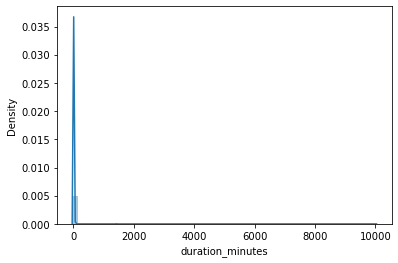

In [18]:
sns.distplot(df.duration_minutes)

There is a very long tail, which obscures what the data looks like. Further info about the data can be shown

In [19]:
df.duration_minutes.describe()

count    3.066766e+06
mean     1.566900e+01
std      4.259435e+01
min     -2.920000e+01
25%      7.116667e+00
50%      1.151667e+01
75%      1.830000e+01
max      1.002918e+04
Name: duration_minutes, dtype: float64

The standard deviation (std) is 42.59

In [20]:
((df.duration_minutes >= 1) & (df.duration_minutes <=60)).mean()

0.9812202822125979

98% of the records are between 1 and 60 minutes.

The outliers are dropped.

In [21]:
df = df[(df.duration_minutes >= 1) & (df.duration_minutes <=60)]

Define categorical variables and numerical variables

In [22]:
categorical = ['PULocationID', 'DOLocationID']
# this can be used to have a naive training without location IDs as categories
# categorical = []
numerical = ['trip_distance']

The categories will be considered numbers, so they need to be cast to strings so they are treated as categories for one-hot encoding.

In [23]:
df[categorical] = df[categorical].astype(str)

Then each of the rows needs to be turned into a dictionary, and passed into the DictVectorizer fit_transform to make a feature matrix

In [24]:
training_dicts = df[categorical + numerical].to_dict(orient='records')

In [25]:
dv = DictVectorizer()
X_train = dv.fit_transform(training_dicts)

In [27]:
len(dv.feature_names_)

516

The number of features is the number of fields is the sparse matrix after one-hot encoding. It includes the single numerical value for duration_minutes as well, so the number of categorical features is 515.

In [28]:
target = 'duration_minutes'
Y_train = df[target].values

Now a linear regression model can be trained

In [29]:
lr = LinearRegression()
lr.fit(X_train, Y_train)

LinearRegression()

A prediction of Y can be made by predicting from the X training matrix. Then it is visualised with sns and plt. The blue prediction is very different to the yellow actual, so it's probably not good.

In [30]:
Y_pred = lr.predict(X_train)

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


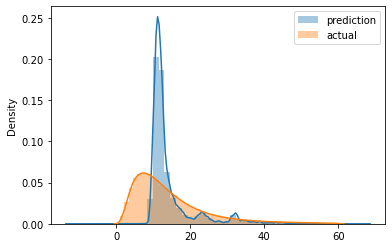

In [31]:
sns.distplot(Y_pred, label='prediction')
sns.distplot(Y_train, label='actual')

plt.legend()

The model can be tested with the root mean squared error (RMSE)

In [32]:
mean_squared_error(Y_train, Y_pred, squared=False)

7.649140464167203

The output of the RMSE is 7.64, which means on average, the model is wrong by 7.64 minutes.

With no categories, it is 9.93.

The set up can be set into a function for easy reuse.

Note that I had been getting many kernel deat

In [17]:
def read_dataframe(filename):
    # read in data to dataframe
    df = pd.read_parquet(filename)

    # convert to pd datetime
    df['tpep_pickup_pd_datetime'] = df.tpep_pickup_datetime
    df['tpep_dropoff_pd_datetime'] = df.tpep_dropoff_datetime

    df.tpep_pickup_pd_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    df.tpep_dropoff_pd_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
    
    # calculate duration
    df['duration'] = df.tpep_dropoff_pd_datetime - df.tpep_pickup_pd_datetime
    
    # convert to minutes
    df['duration_minutes'] = df.duration.apply(lambda td: td.total_seconds() / 60)
    
    # filter to between 1 and 60 minutes
    df = df[(df.duration_minutes >= 1) & (df.duration_minutes <=60)]
    
    # set up variables
    categorical = ['PULocationID', 'DOLocationID']
    
    # cast the categorical to string
    df[categorical] = df[categorical].astype(str)

    return df

In [9]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet')
# df_valid = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet')

The model can be trained and then used on the validation data

In [10]:
categorical = ['PULocationID', 'DOLocationID']
# this can be used to have a naive training without location IDs as categories
# categorical = []
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

# valid_dicts = df_valid[categorical + numerical].to_dict(orient='records')
# transforming without fit(?)
# X_valid = dv.transform(valid_dicts)

In [11]:
target = 'duration_minutes'
Y_train = df_train[target].values
# Y_valid = df_valid[target].values

In [12]:
lr = LinearRegression()
lr.fit(X_train, Y_train)

Y_pred = lr.predict(X_train)

mean_squared_error(Y_train, Y_pred, squared=False)

7.649140464167203

It was as we have before. Now get the february validation dataframe ready.

In [13]:
# df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet')
df_valid = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet')

In [14]:
# categorical = ['PULocationID', 'DOLocationID']
# this can be used to have a naive training without location IDs as categories
# categorical = []
# numerical = ['trip_distance']

# dv = DictVectorizer()

# train_dicts = df_train[categorical + numerical].to_dict(orient='records')
# X_train = dv.fit_transform(train_dicts)

valid_dicts = df_valid[categorical + numerical].to_dict(orient='records')
# transforming without fit(?)
X_valid = dv.transform(valid_dicts)

In [15]:
# target = 'duration_minutes'
# Y_train = df_train[target].values
Y_valid = df_valid[target].values

In [16]:
# lr = LinearRegression()
# lr.fit(X_train, Y_train)

Y_pred_on_valid = lr.predict(X_valid)

mean_squared_error(Y_valid, Y_pred_on_valid, squared=False)

7.811462911207304

The fit of the trained model predicting the validation data is fairly ok, a mean squared error of 7.81, where it was 7.64 when checking against the training data.